# Describing and Exploring the Cleaned Files and Defining Research Questions
#### Jameson Carter, Mihir Bhaskar, Abhilash Biswas
#### 11/26/2021
The following code describes and runs initial exploration on two datasets:
1. CombineData.ipynb, which contains ACS tracts in Chicago and demographic information, complaints made against police officers in those locations, and geographic information about the city of chicago, within those tracts

2. CleanComplaints_FindingLevel.csv (created by 3_CleanComplaints). This file contains complaint-officer level granular data about each complaint and its characteristics.

In this file, we-

 - Provide some initial visualizations that describe/explore these datasets
 - Define our research questions

# Explore the Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from shapely import wkt
from pyprojroot import here
import seaborn as sns
%matplotlib inline

import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
#from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.metrics import r2_score 

In [2]:
data = pd.read_csv(here('./data/Combined.csv'))

complaintsdf = pd.read_csv(here('./data/CleanComplaints_FindingLevel.csv'))

### Evaluating the Target Variable- Complaints

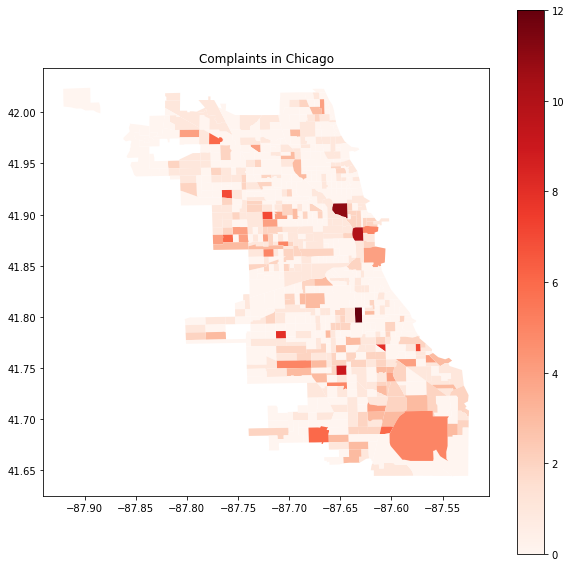

In [3]:
data['geometry'] = gpd.GeoSeries.from_wkt(data['geometry'])
plt.rcParams['figure.figsize'] = [10, 10]
GeoData = gpd.GeoDataFrame(data, geometry='geometry')
GeoData.plot("complaint_count", cmap = "Reds", legend = True)
plt.title('Complaints in Chicago')
plt.grid(False)


The above plot shows that there are a few tracts where complaints are quite high, although there is not a clear geographic relationship. There seem to be higher numbers of complaints on the South Side of the city. 

The plot flags a few tracts as having particularly high complaint incididence:
 - Tract 8356 (12), which is a small tract nestled between a large highway and a railyard on the South side, with a police station nearby.
 - Tract 8422 (11), which is a larger tract containing Goose Island, an island bounded by a canal and a river near a historically poor neighborhood called Cabrini-Green.
 - Tract 1839 (10), is a larger tract nestled between the Chicago River and Lake Michigan, and is nearby the Art Institute of Chicago.
 
I evaluated these tracts using the following https://www.chicagocityscape.com/maps/?place=censustract-17031835600

In [4]:
GeoData.sort_values('complaint_count', ascending = False).head(3)

,geo_id,B01001_001E,DP02_0002PE,DP02_0004PE,DP02_0006PE,DP02_0010PE,DP02_0014PE,DP02_0015PE,DP02_0016E,DP02_0022PE,...,ROBBERY,SEX OFFENSE,STALKING,THEFT,WEAPONS VIOLATION,inv_stop_count,lakeMI_qmile,river_qmile,Rail_emile,MajorRd_qmile
728,1400000US17031835600,896.0,16.5,3.5,39.8,40.2,14.4,60.2,2.08,20.3,...,88.0,5.0,2.0,482.0,62.0,35.0,0.0,0.0,1.0,1.0
781,1400000US17031842200,3362.0,18.2,9.6,36.8,35.4,10.0,18.5,1.62,9.8,...,118.0,21.0,1.0,2928.0,15.0,80.0,0.0,1.0,1.0,1.0
755,1400000US17031839100,7545.0,22.9,8.6,42.6,25.8,4.7,5.2,1.61,6.5,...,580.0,70.0,18.0,11704.0,26.0,47.0,0.0,1.0,1.0,1.0


The following exploration finds that the typical tract (as defined by the median), exhibits no complaints, while the average tract exhibits 0.83 complaints.

In [5]:
GeoData[['complaint_count']].describe()

,complaint_count
count,798.000000
mean,0.810777
std,1.383913
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,12.000000


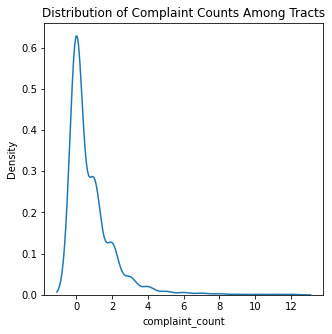

In [6]:
plt.rcParams['figure.figsize'] = [5, 5]
sns.kdeplot(GeoData['complaint_count'])
plt.title('Distribution of Complaint Counts Among Tracts')
plt.grid(False)
plt.show()



### Evaluating relationships between variables

The code below creates a correlation matrix for the dataset, and filters it to those variables with the absolute value of correlation greater than 80% (since there are too many variables to visualize in a complete correlation matrix).

In [7]:
# Moving the target variables so they are at the front of the dataset
target = GeoData.pop('complaint_count')
GeoData.insert(loc=0, column='complaint_count', value=target)

# Generating a correlation matrix
# Note: code below sourced from this link: https://stackoverflow.com/questions/41128456/pandas-filter-across-all-columns
corr = GeoData.corr()

# This code keeps only the upper triangle of the correlation matrix (because the two triangles are copies/repeats)
corr_triu = corr.where(~np.tril(np.ones(corr.shape)).astype(bool))

# This reshapes the matrix to become like a stack, with Var 1, Var 2, and their respective score
corr_triu = corr_triu.stack()

# Making the output more readable
corr_triu.name = 'Correlation Coefficient'
corr_triu.index.names = ['Col1', 'Col2']

# Filtering only those values where absolute value of the correlation is > 80% (i.e. highly correlated variables)
corr_triu = corr_triu[abs(corr_triu) > 0.8].to_frame()

# Ordering from highest correlation to lowest based on absolute correlation
corr_triu.sort_values(by='Correlation Coefficient', key=pd.Series.abs, ascending=False, inplace=True)


#corr_triu.sort_values(by=['Correlation Coefficient'], inplace=True)

print(f'Number of feature pairs that are highly correlated (i.e. >80%): {len(corr_triu)}')

corr_triu


Number of feature pairs that are highly correlated (i.e. >80%): 57


,,Correlation Coefficient
Col1,Col2,
ASSAULT,BATTERY,0.963624
DECEPTIVE PRACTICE,THEFT,0.953793
ASSAULT,OTHER OFFENSE,0.940364
DP02_0015PE,DP03_0066PE,0.940157
BATTERY,OTHER OFFENSE,0.936715
DP03_0004PE,DP03_0013PE,0.925954
DP05_0037PE,DP05_0038PE,-0.923312
DP02_0093PE,DP02_0114PE,0.917271
BATTERY,CRIMINAL DAMAGE,0.914779


There are several feature pairs, that are highly correlated - 57 feature pairs have an absolute correlation coefficient greater than 80%. Some of these variables will need to be dropped based on some other criterion before any modelling efforts.

Some of the other pairs that are highly correlated are:
- Crime count categories (assault and battery, deceptive practice and theft, assault and other offences)
- % of households with social security and households with a member 65+.
- % of population that is employed and % of women who are employed.
- % of population that is white and % of population that is black.
- % of population born abroad and % of population who do not speak English at home, and who do not speak English 'very well.'

Several of these variables will need to be dropped in the modelling effort through selection methods and cleaning. Some are near-mirrors as they account for similar elements to the same issue. 

**The code below now looks at spatial distributions of a few predictors**, to see if there are any geographic patterns

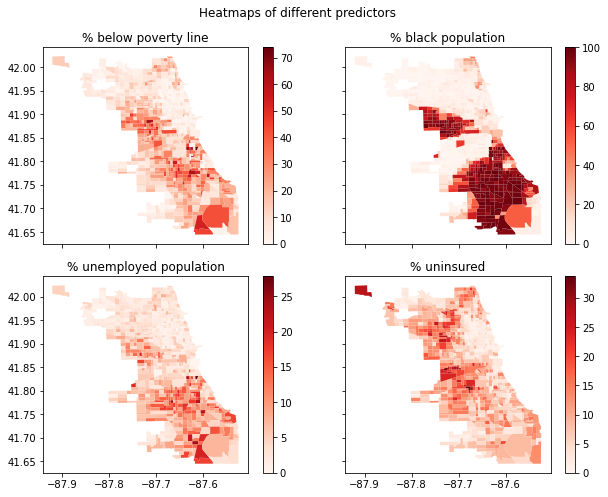

In [8]:
# Variables to create plots for in a loop
variables = ['DP03_0119PE', 'DP05_0038PE', 'DP03_0005PE', 'DP03_0099PE']
titles = ['% below poverty line', '% black population', '% unemployed population', '% uninsured']

# Set up the subplots in a 2x2 grid and initialise the figure
fig, axes = plt.subplots(2,2, figsize=(9,7), sharex=True, sharey=True)
fig.suptitle('Heatmaps of different predictors')

# Loop through both the degree (range from 1-7), and the tile we want the plot in (from the axes)
i = -1
for var, ax in zip(variables, axes.flatten()):
    
    # Create heatmap plot
    GeoData.plot(var, cmap='Reds', legend=True, ax=ax)
    
    # Give it a title according to the titles list
    i += 1
    ax.set_title('{:s}'.format(titles[i]))
    ax.grid(False)

plt.tight_layout()


The plots show:
- A concentration of tracts with a high % of black families and individuals in the south side of the city
- Individuals below the poverty line, and unemployment rates follow a very similar geographic pattern, and are also starker towards the center and south sides of the city
- It is harder to discern a clear pattern in health insurance, although it appears that the largest incidence of uninsurance are in the segments of the city where non-white populations live, as well as a significant population of people without insurance in the whiter areas of the city.

These plots seem to suggest that there are groupings of tracts that share similar characteristics. This informs our third research question, of wanting to explore unsupervised learning to uncover naturally occuring clusters of tracts based on their characteristics.

### Describing the characteristics of the complaints (at the complaint level)

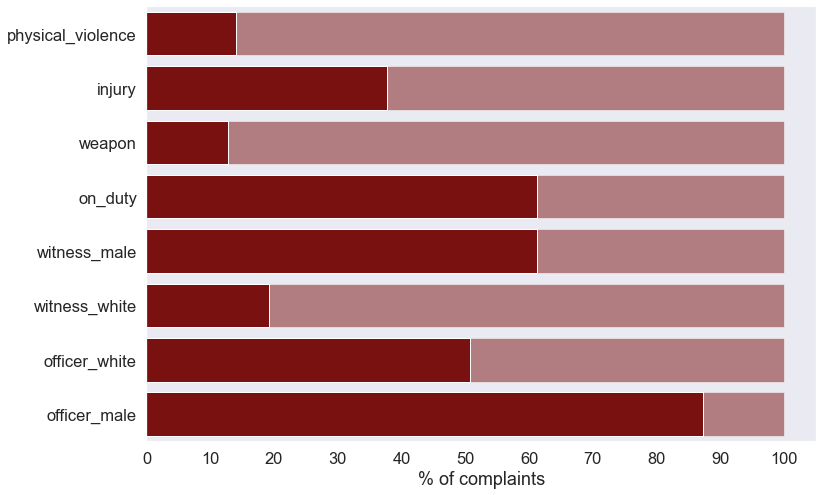

,officer_cmp_count,officer_rank_order,officer_age
count,1180.00000,1174.000000,1174.000000
mean,0.15339,1.149915,45.750426
std,0.45234,0.404172,8.194767
min,0.00000,1.000000,26.000000
25%,0.00000,1.000000,39.000000
50%,0.00000,1.000000,45.000000
75%,0.00000,1.000000,52.000000
max,4.00000,4.000000,68.000000


In [9]:
# Describing complaint characteristics

# Stacked proportion bar chart for dummy variables

## Creating data for graph
graph = complaintsdf[['physical_violence', 'injury', 'weapon', 'on_duty', 'witness_male', 'witness_white', 
    'officer_white', 'officer_male']].mean()

graph = pd.DataFrame(data=graph, columns={'Mean'})

graph.reset_index(inplace=True)

graph['Mean'] = 100*graph['Mean']
graph['Remaining'] = 100 


## Drawing the plot 
plt.figure(figsize=(12, 8))
sns.set(font_scale = 1.5)
bar1 = sns.barplot(y='index', x='Remaining', data=graph, color='darkred', alpha=0.5)
bar2 = sns.barplot(y='index', x='Mean', data=graph, color='darkred')
plt.xlabel('% of complaints')
plt.ylabel('')
plt.xticks(range(0, 101, 10))
plt.grid(False)
plt.show()

# Showing descriptive stats for the numeric variables
complaintsdf[['officer_cmp_count', 'officer_rank_order', 'officer_age']].describe()


Descriptive results:
- **Nature of allegation**: 14% of complaints involved physical violence, 38% led to some form of injury, 13% involved a weapon (display or use), 61% happened while on duty

- **Characteristics of witness/complainant**: 61% of witnesses were male, 19% were white

- **Characteristics of officer**: 51% of officers facing complaints are white, 87% male, almost no officers have had a history of complaints (i.e. appear only once in the dataset), are on average at the lowest levle of police (i.e. regular police officers), and are on average 46 years of age. 

# Defining research questions

## Research Question 1 - Predicting and Classifying Number of Complaints in Census Tracts

### Note: this research question is explored in the file 9_Research Question 1

## Research Question 2 - Clustering Census Tracts’ Characteristics
### Note: this research question is explored in the file 10_Research Question 2

## Research Question 3 - Classifying Complaint Findings
### Note: this research question is explored in the file 11_Research Question 3

## References

 - https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html
 - The in class exercise Clustering-Mini2_JamsonCarter.ipynb
 - https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
 - https://stackoverflow.com/questions/38372188/how-to-add-k-means-predicted-clusters-in-a-column-to-a-dataframe-in-python
 - https://stackoverflow.com/questions/41128456/pandas-filter-across-all-columns
 - https://stackoverflow.com/questions/33575587/pandas-dataframe-how-to-apply-describe-to-each-group-and-add-to-new-columns